# Heterogeneous GNN

In [242]:
# Torch
import torch
from torch_geometric.data import HeteroData, DataLoader, Dataset
from torch_geometric.nn import RGCNConv, global_mean_pool
from torch_geometric.nn import SAGEConv, to_hetero, GCNConv
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, GraphConv, Linear
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import trim_to_layer
from torch_geometric.loader import DataLoader

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# Misc
import os
import time
from math import ceil

In [3]:
PATH_GRAPH_DATA = '../../data/graph-dataset/semester-2/hetero-graph/merged-32/'

class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [4]:
file_name = "1000-1001-1002-1003-1004-1005-1006-1007-1008-1009-1010-1011-1012-1013-1014-1015-1016-1017-1018-1019-1020-1021-1022-1023-1024-1025-1026-1027-1028-1029-1030-1031.pt"
dataset = torch.load(PATH_GRAPH_DATA + file_name)

In [5]:
dataset

InfernoDataset(173868)

In [204]:
class HeterogeneousGNN(torch.nn.Module):

    def __init__(self, hidden_channels, conv_layers, dense_layers, edge_types):
        super().__init__()

        torch.manual_seed(42)

        self.convs = torch.nn.ModuleList()
        for layernum in range(conv_layers):
            conv = HeteroConv({
                    edge_type: SAGEConv((-1, -1), hidden_channels)
                    for edge_type in edge_types
                }, aggr='mean')
            self.convs.append(conv)

        self.linear = Linear(-1, dense_layers[0]['input_neuron_num'])
        
        # Create dense layers based on the 'dense_layers' parameter
        dense_layers_container = []
        for layer_config in dense_layers:

            if layer_config['dropout'] == 0:
                # Add the first layer manually because it has a different input size
                dense_layers_container.append(torch.nn.Linear(layer_config['input_neuron_num'], layer_config['neuron_num']))
                
                # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                if layer_config['activation_function'] is not None:
                    dense_layers_container.append(layer_config['activation_function'])

                # Add the rest of the layers (if there are any)
                for _ in range(layer_config['num_of_layers'] - 1):
                    dense_layers_container.append(torch.nn.Linear(layer_config['neuron_num'], layer_config['neuron_num']))

                    # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                    if layer_config['activation_function'] is not None:
                        dense_layers_container.append(layer_config['activation_function'])
            else:
                dense_layers_container.append(torch.nn.Dropout(layer_config['dropout']))
        
        self.dense = torch.nn.Sequential(*dense_layers_container)
        

    def forward(self, x_dict, edge_index_dict, y):
      graph_data = torch.tensor([
          y['match_id'],
          y['roundNum'],
          y['time_remaining'],
          y['tScore'],
          y['ctScore'],
          y['CT_aliveNum'],
          y['T_aliveNum'],
          y['CT_equipmentValue'],
          y['T_equipmentValue'],
          y['is_bomb_being_planted'],
          y['is_bomb_planted_at_A_site'],
          y['is_bomb_planted_at_B_site'],
          y['is_bomb_being_defused'],
          y['is_bomb_defused'],
          y['bomb_mx_pos1'],
          y['bomb_mx_pos2'],
          y['bomb_mx_pos3'],
          y['bomb_mx_pos4'],
          y['bomb_mx_pos5'],
          y['bomb_mx_pos6'],
          y['bomb_mx_pos7'],
          y['bomb_mx_pos8'],
          y['bomb_mx_pos9'],
      ]).to('cuda')

      edge_index_dict = {key: value.to(torch.int64) for key, value in edge_index_dict.items()}

      for conv in self.convs:
          temp = conv(x_dict, edge_index_dict)
          x_dict['map'] = torch.cat([x_dict['map'][:,:5],temp['map']],dim=1)
          x_dict = {key: x.relu() for key, x in x_dict.items()}

      # With flattem
      x = torch.cat([torch.flatten(x_dict['player']), torch.flatten(x_dict['map']), torch.flatten(graph_data)])

      # Global mean pool
      #one = global_mean_pool(x_dict['player'],None)
      #two = global_mean_pool(x_dict['map'], None)
      #x = torch.cat([torch.flatten(x_dict['player']), torch.flatten(two)])

      x = self.linear(x)
      x = self.dense(x)
      return x

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 3,
        "input_neuron_num": 2048,
        "neuron_num": 2048,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 3,
        "input_neuron_num": 2048,
        "neuron_num": 512,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "input_neuron_num": 512,
        "neuron_num": 64,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "input_neuron_num": 64,
        "neuron_num": 16,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "input_neuron_num": 16,
        "neuron_num": 4,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "input_neuron_num": 4,
        "neuron_num": 1,
        "activation_function": None
    },
]
model = HeterogeneousGNN(hidden_channels=30, conv_layers=10, dense_layers=dense_layers, edge_types=dataset[0].edge_types)

In [205]:
torch.manual_seed(42)
permuted_indices = torch.randperm(len(dataset))
shuffled_dataset = dataset[permuted_indices]

In [207]:
zeros = 0
ones = 0
for data in shuffled_dataset[:2000]:
    if data.y['CT_winsRound'] == 0:
        zeros += 1
    else:
        ones += 1

print(f"Zeros: {zeros}")
print(f"Ones: {ones}")

Zeros: 1126
Ones: 874


In [208]:
train_loader = DataLoader(shuffled_dataset[:2000], batch_size=1, shuffle=False)
val_loader = DataLoader(shuffled_dataset[2000:4000], batch_size=1, shuffle=False)
data = dataset[0].to('cuda')

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 2048,
        "input_neuron_num": 2048,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 512,
        "input_neuron_num": 2048,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 64,
        "input_neuron_num": 512,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.5,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 16,
        "input_neuron_num": 64,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 4,
        "input_neuron_num": 16,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 4,
        "activation_function": None
    },
]

model = HeterogeneousGNN(hidden_channels=15, conv_layers=10, dense_layers=dense_layers, edge_types=data.edge_types).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_function = torch.nn.BCEWithLogitsLoss()


with torch.no_grad():  # Initialize lazy modules.
     out = model(data.x_dict, data.edge_index_dict, data.y)
     print(torch.sigmoid(out))

     
print('params:', sum(p.numel() for p in model.parameters()))
print('trainable:', sum(p.numel() for p in model.parameters() if p.requires_grad))

tensor([0.3634], device='cuda:0')
params: 19421500
trainable: 19421500


In [284]:
def train(epochs):

    train_losses = []
    val_losses = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        total_loss = 0
        
        for data in train_loader:  # Iterate in batches over the training dataset.
            data = data.to('cuda')
            optimizer.zero_grad()  # Clear gradients.
            
            out = model(data.x_dict, data.edge_index_dict, data.y).float()  # Perform a single forward pass.
            target = torch.tensor(data.y['CT_winsRound']).float().to('cuda')  # Assuming target is stored in data.y

            loss = loss_function(out, target)  # Compute the loss.
            loss.backward()  # Backpropagate.
            optimizer.step()  # Update model parameters.

            total_loss += loss.item()  # Accumulate the loss.


        train_avg_loss = total_loss / len(train_loader)
        val_metrics = validate(val_loader)  # Validate the model on validation dataset.
        epoch_end = time.time()

        val_avg_loss = val_metrics[0]
        accuracy = val_metrics[1]
        precision = val_metrics[2]
        recall = val_metrics[3]
        f1 = val_metrics[4]
        cm = val_metrics[5]
        cm_normalized = val_metrics[6]
        fpr, tpr = val_metrics[7], val_metrics[8]

        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print("------------------------------------------------------------\n"
             f"                       Epoch {epoch}\n"
              "------------------------------------------------------------\n"
             f"Runtime: {epoch_end - epoch_start}s \n"
              "Training results:\n"
             f"   - Average loss: {train_avg_loss:.4f} \n"
              "Validation results: \n"
             f"     - Average loss: {val_avg_loss} \n"
             f"     - Accuracy: {accuracy} \n"
             f"     - Precision: {precision} \n"
             f"     - Recall: {recall} \n"
             f"     - F1: {f1} \n"
              "     - Confusion matrix & ROC/AUC: \n")
        
        # ----------------------------------------
        # Confusion matrix & ROC/AUC visualization
        # ----------------------------------------

        fig, axs = plt.subplots(1, 3, figsize=(8, 3))
        fig.suptitle(f'Epoch {epoch} - Validation scores', fontsize=12)


        # Confusion Matrix
        im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
        axs[0].set_aspect('equal')
        axs[0].set_title('Confusion matrix', fontsize=10, y=1)
        axs[0].set_xlabel('Predicted', fontsize=8)
        axs[0].set_ylabel('Actual', fontsize=8)
        # Add numbers to the confusion matrix
        for (i, j), val in np.ndenumerate(cm):
            axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
        # Set x-ticks to bottom
        axs[0].set_xticks([0, 1])
        axs[0].set_xticklabels([0, 1])
        axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


        # Normalized Confusion Matrix
        im = axs[1].matshow(cm_normalized, cmap='Blues', alpha=0.6)
        axs[1].set_aspect('equal')
        axs[1].set_title('Normalized confusion matrix', fontsize=10, y=1)
        axs[1].set_xlabel('Predicted', fontsize=8)
        # Add numbers to the normalized confusion matrix
        for (i, j), val in np.ndenumerate(cm_normalized):
            axs[1].text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=10, color='black')
        # Set x-ticks to bottom
        axs[1].set_xticks([0, 1])
        axs[1].set_xticklabels([0, 1])
        axs[1].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


        # ROC/AUC Curve
        axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC = %0.2f' % auc(fpr, tpr))
        axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[2].set_xlim([0.0, 1.0])
        axs[2].set_ylim([0.0, 1.05])
        axs[2].set_xlabel('False Positive Rate', fontsize=8)
        axs[2].set_ylabel('True Positive Rate', fontsize=8)
        axs[2].set_title('ROC/AUC Curve', fontsize=10, y=1.05)
        axs[2].legend(loc="lower right", fontsize=8)
        axs[2].set_aspect('equal')


        plt.tight_layout()
        plt.show()



        # ----------------------------------------
        # Metrics visualization
        # ----------------------------------------

        fig, axs = plt.subplots(2, 3, figsize=(8, 4.5))
        fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=12)

        epochs_range = np.arange(0, epoch + 1)

        def plot_metric(ax, data, title, ylabel, color):
            if len(data) == 1:
                ax.scatter(epochs_range, data, s=10, c=color)
            else:
                ax.plot(epochs_range, data, marker='o', linestyle='-', color=color)
            ax.set_title(title, fontsize=10)
            ax.set_xlabel('Epoch', fontsize=8)
            ax.set_ylabel(ylabel, fontsize=8)
            ax.set_xticks(epochs_range)
            if 'Loss' not in title:
                ax.set_ylim(0, 1)
            ax.grid(True)

        plot_metric(axs[0, 0], train_losses, 'Train Loss', 'Loss', 'cornflowerblue')
        plot_metric(axs[0, 1], val_losses, 'Validation Loss', 'Loss', 'darkorange')
        plot_metric(axs[0, 2], accuracies, 'Accuracy', 'Accuracy', 'limegreen')
        plot_metric(axs[1, 0], precisions, 'Precision', 'Precision', 'red')
        plot_metric(axs[1, 1], recalls, 'Recall', 'Recall', 'teal')
        plot_metric(axs[1, 2], f1_scores, 'F1 Score', 'F1 Score', 'black')

        plt.tight_layout()
        plt.show()




def validate(val_loader):
    model.eval()  # Átkapcsoljuk a modellt értékelési üzemmódba.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in val_loader:  # Iterálunk a validációs adatokon.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y).float()
            target = torch.tensor(data.y['CT_winsRound']).float().to('cuda')

            loss = loss_function(out, target)
            total_loss += loss.item()
            total_samples += len(target)

            # Ellenőrizzük a helyes előrejelzéseket (például egy bináris probléma esetében).
            predictions = (torch.sigmoid(out) > 0.5).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Kiszámítjuk az átlagos veszteséget és a pontosságot.
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(targets_all, predictions_all)
    precision = precision_score(targets_all, predictions_all)
    recall = recall_score(targets_all, predictions_all)
    f1 = f1_score(targets_all, predictions_all)
    cm = confusion_matrix(targets_all, predictions_all)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    return avg_loss, accuracy, precision, recall, f1, cm, cm_normalized, fpr, tpr


In [189]:
data.to('cpu')
model.to('cpu');

In [191]:
data.to('cuda')
model.to('cuda');

------------------------------------------------------------
                       Epoch 0
------------------------------------------------------------
Runtime: 59.247222661972046s 
Training results:
   - Average loss: 0.3285 
Validation results: 
     - Average loss: 0.5850935820082168 
     - Accuracy: 0.7045 
     - Precision: 0.8536036036036037 
     - Recall: 0.41878453038674035 
     - F1: 0.5618977020014826 
     - Confusion matrix & ROC/AUC: 



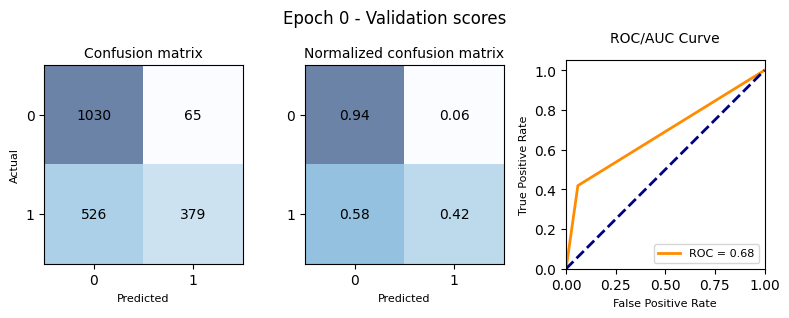

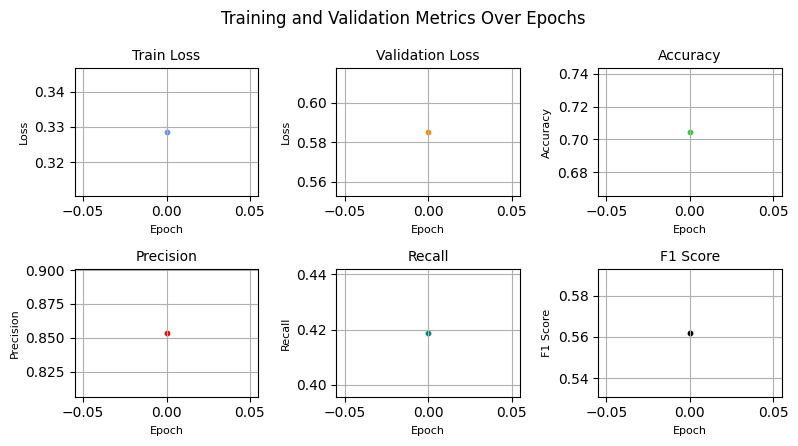

------------------------------------------------------------
                       Epoch 1
------------------------------------------------------------
Runtime: 59.577715158462524s 
Training results:
   - Average loss: 0.3236 
Validation results: 
     - Average loss: 0.7158835224130831 
     - Accuracy: 0.7255 
     - Precision: 0.7825396825396825 
     - Recall: 0.5447513812154696 
     - F1: 0.6423452768729642 
     - Confusion matrix & ROC/AUC: 



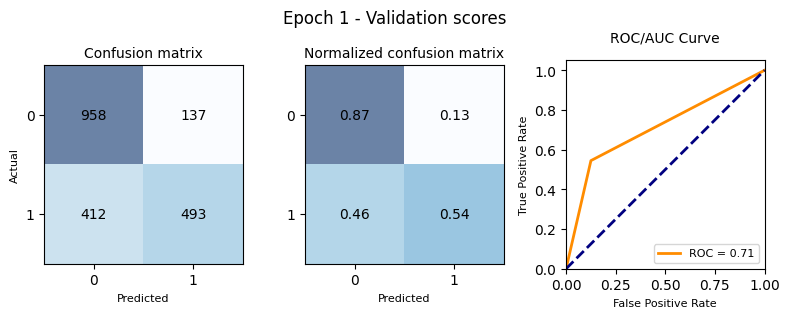

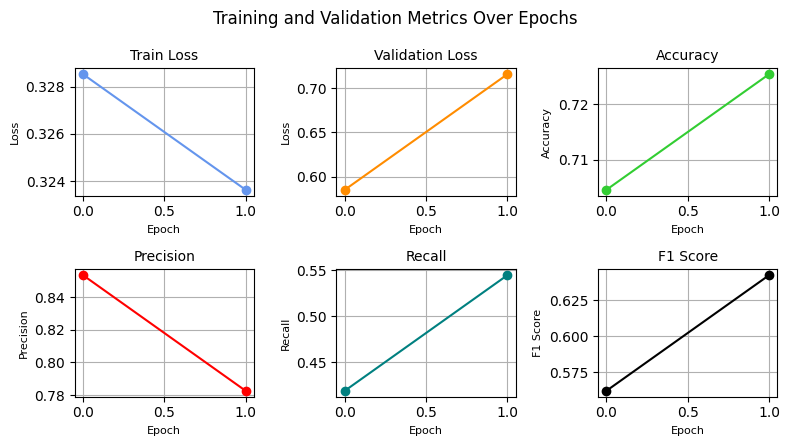

------------------------------------------------------------
                       Epoch 2
------------------------------------------------------------
Runtime: 59.512423515319824s 
Training results:
   - Average loss: 0.3411 
Validation results: 
     - Average loss: 0.8890898881517666 
     - Accuracy: 0.7245 
     - Precision: 0.7739938080495357 
     - Recall: 0.5524861878453039 
     - F1: 0.6447453255963895 
     - Confusion matrix & ROC/AUC: 



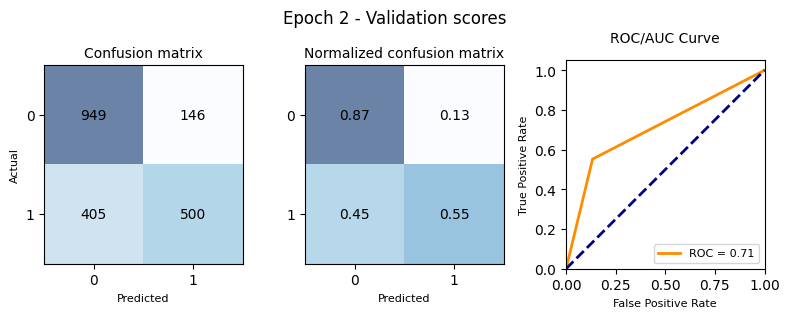

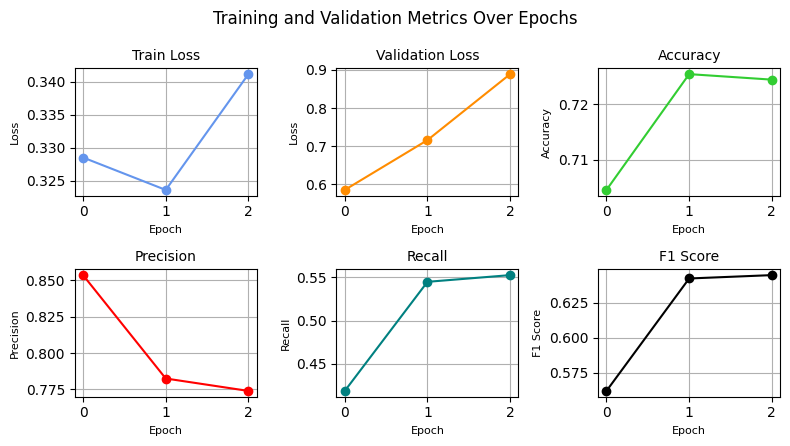

------------------------------------------------------------
                       Epoch 3
------------------------------------------------------------
Runtime: 60.25115418434143s 
Training results:
   - Average loss: 0.3284 
Validation results: 
     - Average loss: 0.8643641487187397 
     - Accuracy: 0.7185 
     - Precision: 0.8 
     - Recall: 0.5038674033149171 
     - F1: 0.6183050847457626 
     - Confusion matrix & ROC/AUC: 



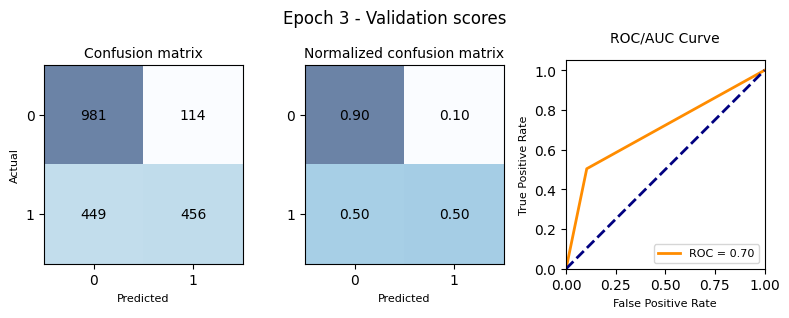

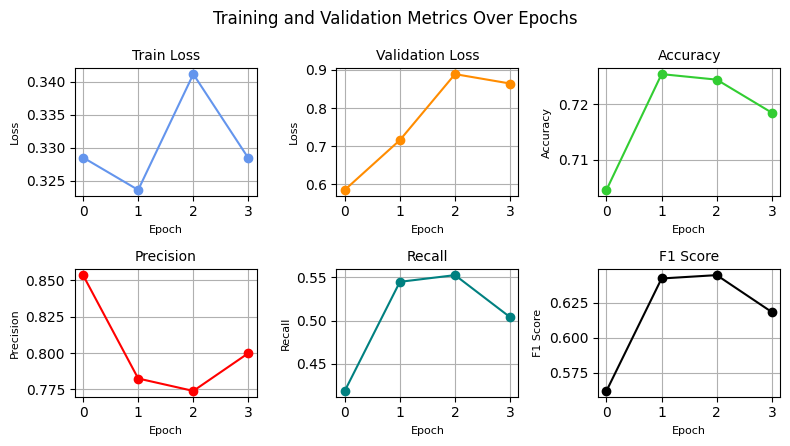

------------------------------------------------------------
                       Epoch 4
------------------------------------------------------------
Runtime: 64.9158365726471s 
Training results:
   - Average loss: 0.4215 
Validation results: 
     - Average loss: 0.5929221645245341 
     - Accuracy: 0.74 
     - Precision: 0.7272727272727273 
     - Recall: 0.6806629834254143 
     - F1: 0.7031963470319634 
     - Confusion matrix & ROC/AUC: 



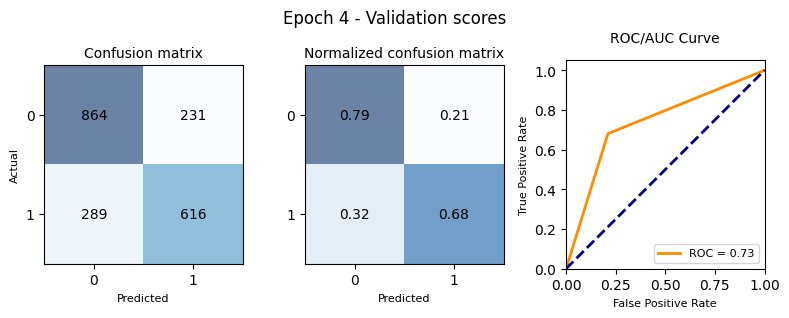

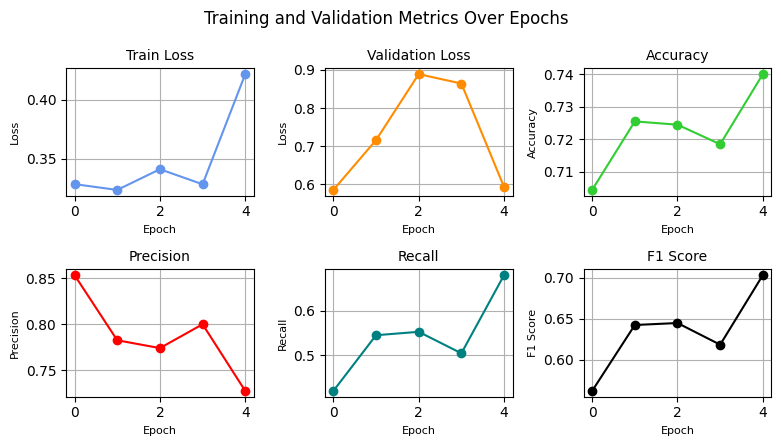

------------------------------------------------------------
                       Epoch 5
------------------------------------------------------------
Runtime: 61.016050577163696s 
Training results:
   - Average loss: 0.2930 
Validation results: 
     - Average loss: 0.7605750816911165 
     - Accuracy: 0.7155 
     - Precision: 0.8373493975903614 
     - Recall: 0.4607734806629834 
     - F1: 0.5944404846756949 
     - Confusion matrix & ROC/AUC: 



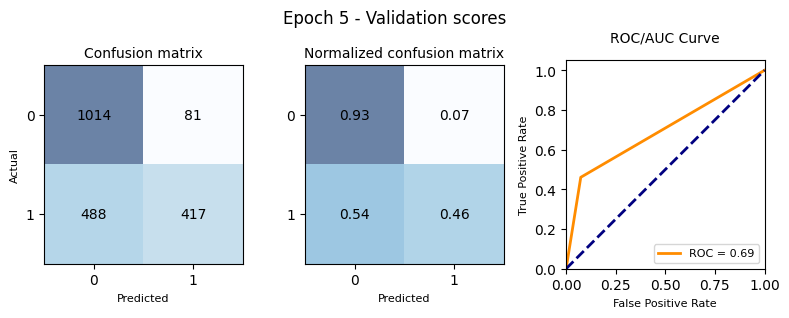

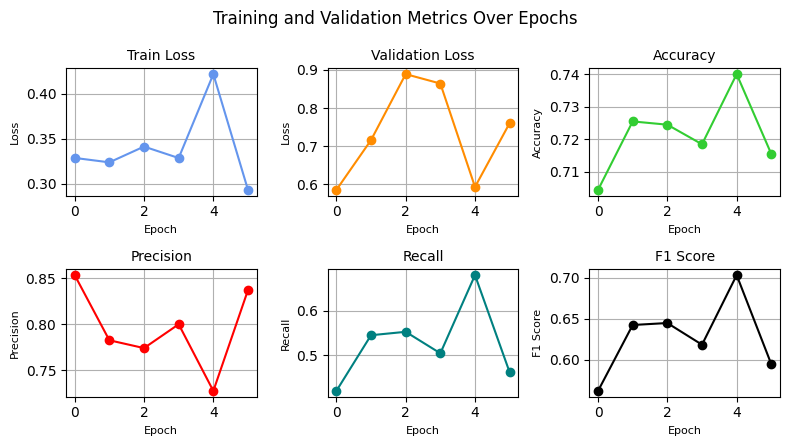

------------------------------------------------------------
                       Epoch 6
------------------------------------------------------------
Runtime: 61.63846731185913s 
Training results:
   - Average loss: 0.3130 
Validation results: 
     - Average loss: 0.8616846353991525 
     - Accuracy: 0.726 
     - Precision: 0.7553648068669528 
     - Recall: 0.5834254143646409 
     - F1: 0.6583541147132169 
     - Confusion matrix & ROC/AUC: 



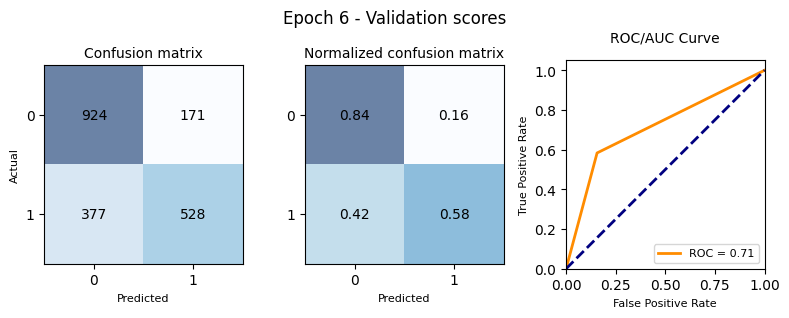

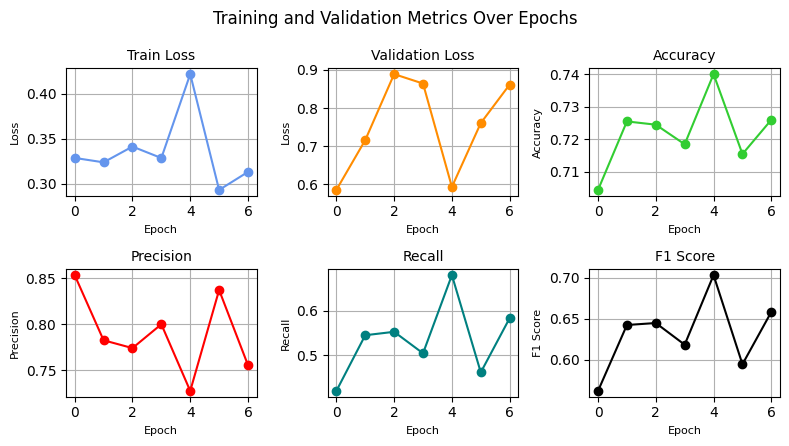

------------------------------------------------------------
                       Epoch 7
------------------------------------------------------------
Runtime: 60.08685922622681s 
Training results:
   - Average loss: 0.2668 
Validation results: 
     - Average loss: 0.6066027943141268 
     - Accuracy: 0.7085 
     - Precision: 0.8194444444444444 
     - Recall: 0.456353591160221 
     - F1: 0.5862313697657914 
     - Confusion matrix & ROC/AUC: 



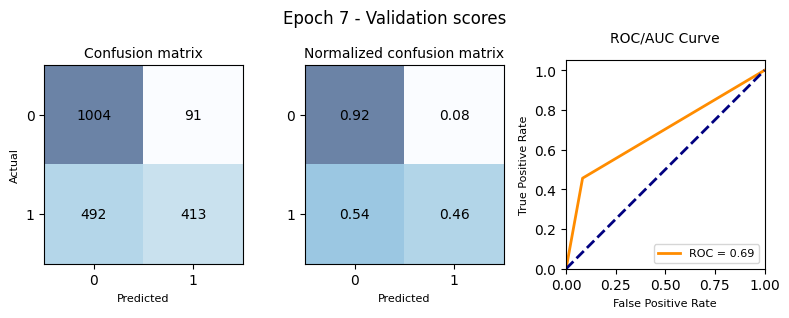

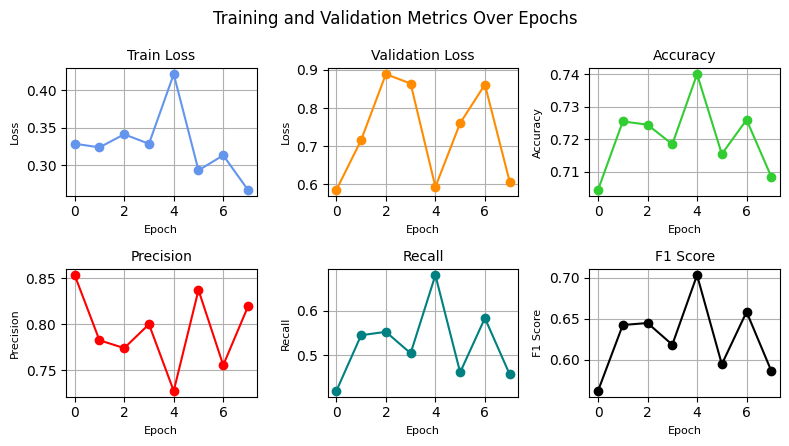

------------------------------------------------------------
                       Epoch 8
------------------------------------------------------------
Runtime: 59.469908714294434s 
Training results:
   - Average loss: 0.3339 
Validation results: 
     - Average loss: 0.9290017343126746 
     - Accuracy: 0.716 
     - Precision: 0.8259187620889749 
     - Recall: 0.4718232044198895 
     - F1: 0.60056258790436 
     - Confusion matrix & ROC/AUC: 



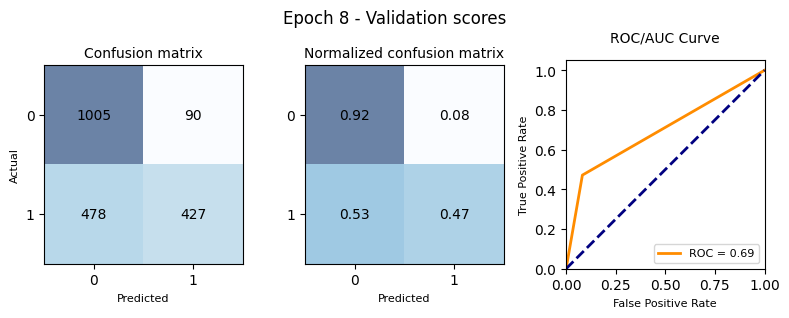

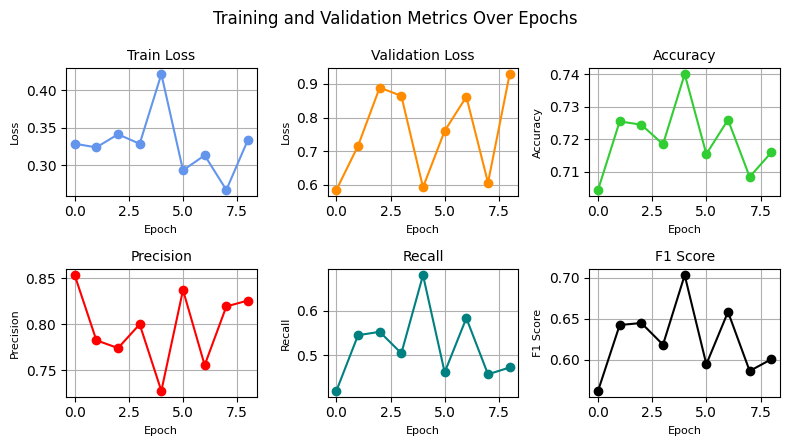

------------------------------------------------------------
                       Epoch 9
------------------------------------------------------------
Runtime: 60.349334716796875s 
Training results:
   - Average loss: 0.3233 
Validation results: 
     - Average loss: 0.7362635155837122 
     - Accuracy: 0.7295 
     - Precision: 0.7556179775280899 
     - Recall: 0.594475138121547 
     - F1: 0.6654298082869512 
     - Confusion matrix & ROC/AUC: 



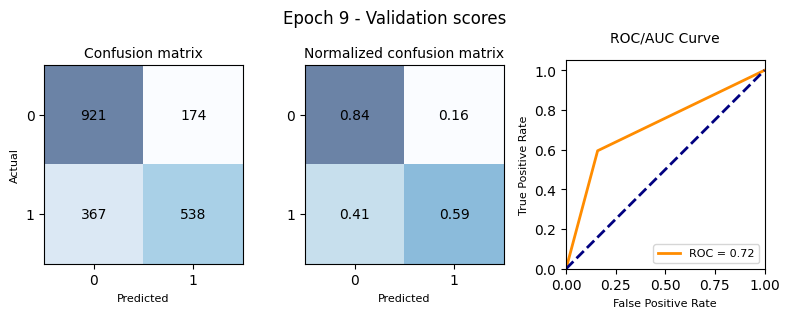

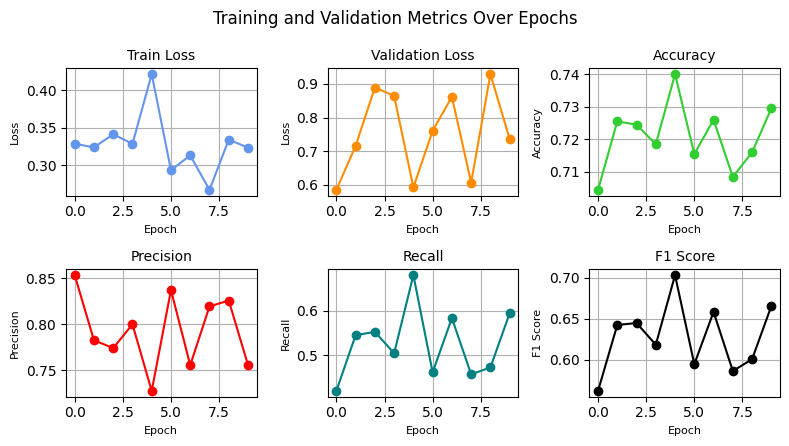

In [282]:
train(epochs=10)